In [1]:
import numpy as np
import pandas as pd
import datetime
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

/Users/narimatsu_n/.pyenv/versions/3.5.0/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [3]:
df_train = df_train[df_train.target >= -30].reset_index(drop=True)

In [4]:
df_hist_trans['purchase_amount'] = np.exp(df_hist_trans['purchase_amount'])
df_new_merchant_trans['purchase_amount'] = np.exp(df_new_merchant_trans['purchase_amount'])

In [5]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [6]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [7]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [8]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

138

In [9]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

138

In [10]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_subsector_id_nunique,hist_year_nunique,hist_month_nunique,hist_purchase_amount_sum,...,new_hist_hour_nunique,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_diff_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,21,2,9,145.779172,...,8.0,2018-04-29 11:23:05,2018-03-05 14:04:36,10.304348,0.0,0.000000,1.381361e+36,54.0,2.347826,250.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,24,2,12,303.155999,...,5.0,2018-03-30 06:48:26,2018-02-01 17:07:54,11.500000,0.0,0.000000,3.557623e+25,56.0,9.333333,280.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,7,2,10,21.917329,...,1.0,2018-04-28 17:43:11,2018-04-28 17:43:11,10.000000,0.0,0.000000,1.381361e+36,0.0,0.000000,250.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,13,2,6,43.344120,...,5.0,2018-04-18 11:00:11,2018-03-07 11:55:06,10.428571,1.0,0.142857,1.973373e+35,41.0,5.857143,261.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,17,2,4,4916.562107,...,14.0,2018-04-28 18:50:25,2018-03-02 11:55:43,10.277778,2.0,0.055556,3.624714e+107,57.0,1.583333,250.0


In [11]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
Name: outliers, dtype: int64

In [12]:
list_outlier_idx = df_train[df_train.outliers == 1].index.tolist()

In [13]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [14]:
high_importance_features = [
    "hist_month_diff_mean", 
    "hist_authorized_flag_mean", 
    "hist_category_1_sum", 
    "hist_month_lag_mean", 
    "new_hist_purchase_amount_sum", 
    "new_hist_purchase_date_uptonow"
]

#smoothing
for col in high_importance_features:
    df_train[col] = np.where(df_train[col].values==0, 0.001, df_train[col].values)
    df_test[col] = np.where(df_test[col].values==0, 0.001, df_test[col].values)


for i in range(len(high_importance_features)):
    for j in range(len((high_importance_features)))[i+1:]:
        col1 = high_importance_features[i]
        col2 = high_importance_features[j]
        new_col_name = "{c1}__div__{c2}".format(c1=col1, c2=col2)
        
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

In [15]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [16]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")
df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/purchase_amount_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/feature_nunique_marchant__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_most_used_city_id.csv")
df_train, df_test = merge_new_feature("../input/feature_most_used_state_id.csv")
df_train, df_test = merge_new_feature("../input/feature_term_from_second_latest_to_latest.csv")
df_train, df_test = merge_new_feature("../input/feature_purchase_amount_mean_max_increase.csv")
df_train, df_test = merge_new_feature("../input/feature_frequency_mean_increase_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_card_count_increase_rate.csv")

In [17]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [18]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers']]
target = df_train['target']
target_outlier = df_train["outliers"]

In [19]:
categorical_feats = [
    "feature_1",
    "feature_2",
    "feature_3",
    "most_used_city_id",
    "most_used_state_id"
]

In [20]:
df_train.shape

(199710, 282)

In [21]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': 8,  # -1
    "max_bin": 256,  # なし
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.65339	valid_1's rmse: 1.65295
[200]	training's rmse: 1.61799	valid_1's rmse: 1.61924
[300]	training's rmse: 1.5965	valid_1's rmse: 1.60026
[400]	training's rmse: 1.58212	valid_1's rmse: 1.58876
[500]	training's rmse: 1.57152	valid_1's rmse: 1.58164
[600]	training's rmse: 1.56314	valid_1's rmse: 1.57667
[700]	training's rmse: 1.55606	valid_1's rmse: 1.57326
[800]	training's rmse: 1.54988	valid_1's rmse: 1.5707
[900]	training's rmse: 1.54442	valid_1's rmse: 1.56876
[1000]	training's rmse: 1.53951	valid_1's rmse: 1.56709
[1100]	training's rmse: 1.53502	valid_1's rmse: 1.56591
[1200]	training's rmse: 1.53078	valid_1's rmse: 1.56499
[1300]	training's rmse: 1.5268	valid_1's rmse: 1.56427
[1400]	training's rmse: 1.52308	valid_1's rmse: 1.56363
[1500]	training's rmse: 1.51958	valid_1's rmse: 1.56307
[1600]	training's rmse: 1.51617	valid_1's rmse: 1.56263
[1700]	training's rmse: 1.51298	valid_1's rmse

[2300]	training's rmse: 1.49615	valid_1's rmse: 1.56581
[2400]	training's rmse: 1.4937	valid_1's rmse: 1.56572
[2500]	training's rmse: 1.49137	valid_1's rmse: 1.5656
[2600]	training's rmse: 1.48905	valid_1's rmse: 1.5655
[2700]	training's rmse: 1.48682	valid_1's rmse: 1.56541
[2800]	training's rmse: 1.48464	valid_1's rmse: 1.5653
[2900]	training's rmse: 1.48251	valid_1's rmse: 1.56525
[3000]	training's rmse: 1.48043	valid_1's rmse: 1.56516
[3100]	training's rmse: 1.47843	valid_1's rmse: 1.56513
[3200]	training's rmse: 1.47642	valid_1's rmse: 1.56504
[3300]	training's rmse: 1.47444	valid_1's rmse: 1.56499
[3400]	training's rmse: 1.47249	valid_1's rmse: 1.56491
[3500]	training's rmse: 1.47054	valid_1's rmse: 1.5649
[3600]	training's rmse: 1.46866	valid_1's rmse: 1.56487
[3700]	training's rmse: 1.4668	valid_1's rmse: 1.56483
[3800]	training's rmse: 1.46501	valid_1's rmse: 1.56484
[3900]	training's rmse: 1.46317	valid_1's rmse: 1.56482
[4000]	training's rmse: 1.46137	valid_1's rmse: 1.5647

1.5659403507973413

In [22]:
# num = int(feature_importance_df.shape[0] * 0.8)
# new_columns = feature_importance_df.sort_values(by="importance", ascending=False).Feature.values[:num]

In [23]:
# score:  3.6467757129353053

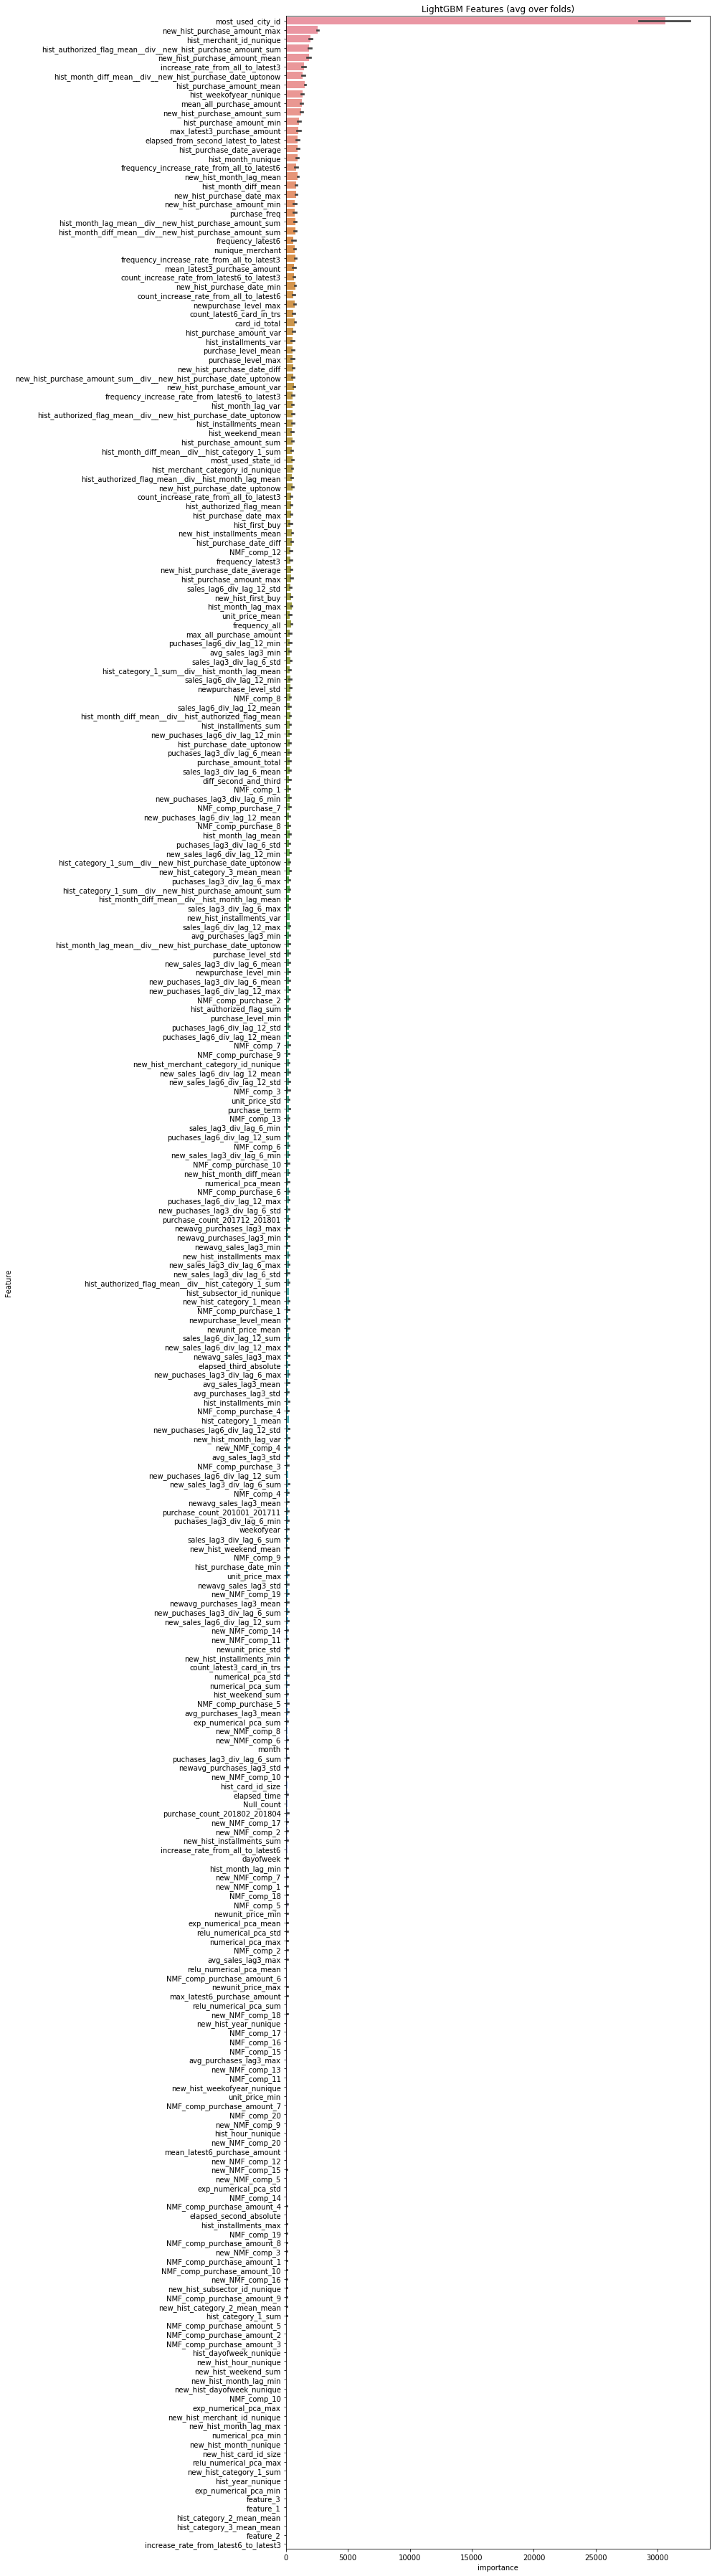

In [24]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [64]:
df_train2 = df_train[df_train.target >= -20].reset_index(drop=True)
target2 = df_train2["target"]

#original
param2 = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': 8,  # -1
    "max_bin": 256,  # なし
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2,df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_columns], label=target2.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_columns], label=target2.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target2))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.607	valid_1's rmse: 1.60676
[200]	training's rmse: 1.5754	valid_1's rmse: 1.57829
[300]	training's rmse: 1.56019	valid_1's rmse: 1.56714
[400]	training's rmse: 1.54981	valid_1's rmse: 1.56154
[500]	training's rmse: 1.54169	valid_1's rmse: 1.55798
[600]	training's rmse: 1.53483	valid_1's rmse: 1.55577
[700]	training's rmse: 1.52889	valid_1's rmse: 1.55431
[800]	training's rmse: 1.52347	valid_1's rmse: 1.55327
[900]	training's rmse: 1.51851	valid_1's rmse: 1.55257
[1000]	training's rmse: 1.51382	valid_1's rmse: 1.55215
[1100]	training's rmse: 1.50941	valid_1's rmse: 1.55189
[1200]	training's rmse: 1.50514	valid_1's rmse: 1.5517
[1300]	training's rmse: 1.501	valid_1's rmse: 1.55143
[1400]	training's rmse: 1.49692	valid_1's rmse: 1.5513
[1500]	training's rmse: 1.49294	valid_1's rmse: 1.55117
[1600]	training's rmse: 1.48898	valid_1's rmse: 1.551
[1700]	training's rmse: 1.48512	valid_1's rmse: 1.55

[800]	training's rmse: 1.51761	valid_1's rmse: 1.57983
[900]	training's rmse: 1.5126	valid_1's rmse: 1.57917
[1000]	training's rmse: 1.5079	valid_1's rmse: 1.57871
[1100]	training's rmse: 1.50348	valid_1's rmse: 1.5783
[1200]	training's rmse: 1.49903	valid_1's rmse: 1.578
[1300]	training's rmse: 1.49486	valid_1's rmse: 1.57779
[1400]	training's rmse: 1.49073	valid_1's rmse: 1.57763
[1500]	training's rmse: 1.48673	valid_1's rmse: 1.57754
[1600]	training's rmse: 1.48281	valid_1's rmse: 1.5774
[1700]	training's rmse: 1.47895	valid_1's rmse: 1.57731
[1800]	training's rmse: 1.47514	valid_1's rmse: 1.57726
[1900]	training's rmse: 1.47145	valid_1's rmse: 1.57714
[2000]	training's rmse: 1.46773	valid_1's rmse: 1.57712
[2100]	training's rmse: 1.46407	valid_1's rmse: 1.57699
[2200]	training's rmse: 1.46043	valid_1's rmse: 1.5769
[2300]	training's rmse: 1.45687	valid_1's rmse: 1.57686
[2400]	training's rmse: 1.4533	valid_1's rmse: 1.57687
[2500]	training's rmse: 1.44979	valid_1's rmse: 1.57695
[2

1.5562508834855548

In [65]:
df_prediction = pd.DataFrame({"prediction1":predictions, "prediction2":predictions2})
df_prediction

,prediction1,prediction2
0,-1.924357,-0.511707
1,-0.240057,-0.262850
2,-0.967147,-0.423405
3,-0.108497,-0.068880
4,-1.497568,-1.845829
5,-0.008423,0.589582
6,0.064930,0.145572
7,0.568618,0.878082
8,-0.773132,-0.700167
9,-0.908505,-0.154173


In [66]:
predictions3 = np.zeros(df_prediction.shape[0])
for i, r in df_prediction.iterrows():
    if r[0] < 0 :
        predictions3[i] = r[0]
    else:
        predictions3[i] = r[1]
df_prediction["prediction3"] = predictions3

In [67]:
df_prediction

,prediction1,prediction2,prediction3
0,-1.924357,-0.511707,-1.924357
1,-0.240057,-0.262850,-0.240057
2,-0.967147,-0.423405,-0.967147
3,-0.108497,-0.068880,-0.108497
4,-1.497568,-1.845829,-1.497568
5,-0.008423,0.589582,-0.008423
6,0.064930,0.145572,0.145572
7,0.568618,0.878082,0.878082
8,-0.773132,-0.700167,-0.773132
9,-0.908505,-0.154173,-0.908505


In [68]:
final_predictions = df_prediction.prediction3.values

In [69]:
# import optuna

# def objective(trial):
#     train_x, test_x, train_y, test_y = train_test_split(df_train[df_train_columns], target, test_size=0.20, random_state=4590)
    
#     dtrain = lgb.Dataset(train_x, label=train_y)
#     dval = lgb.Dataset(test_x, label=test_y)

#     num_round = trial.suggest_int('num_round', 1, 10000)
#     param = {
#         'objective': 'regression', 
#         'metric': 'rmse',
#         'verbosity': -1,
#         'feature_fraction': trial.suggest_loguniform('feature_fraction', 0.8, 0.95),
#         'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.8, 0.95),
#         'bagging_seed': 11,
#         'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
#         'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 10, 1000),
#         'lambda_l1':  trial.suggest_loguniform('lambda_l1', 1e-2, 1.0)
#     }

#     if param['boosting_type'] == 'dart':
#         param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-4, 1.0)
#         param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-4, 1.0)
#     if param['boosting_type'] == 'goss':
#         param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
#         param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

#     gbm = lgb.train(param, dtrain, num_round, valid_sets = [dtrain, dval], verbose_eval=100, early_stopping_rounds=400)
#     preds = gbm.predict(test_x)
#     pred_labels = np.rint(preds)
#     rmse = np.sqrt(mean_squared_error(test_y, pred_labels))
#     return rmse

# study = optuna.create_study()
# study.optimize(objective, n_trials=20)

# print('Number of finished trials: {}'.format(len(study.trials)))

# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))

# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [35]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../output/submission_model_20181216_20190104.csv", index=False)